In [1]:

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
# import pickle
import torch, torch.nn as nn, torch.optim as optim


Dataset Download

In [2]:
# !mkdir -p ./data/mirflickr
# !wget -nc -P ./data/mirflickr http://press.liacs.nl/mirflickr/mirflickr25k.v3b/mirflickr25k.zip
# !unzip -n ./data/mirflickr/mirflickr25k.zip -d ./data/mirflickr > /dev/null

In [3]:
def load_metadata(meta_path="./data/mirflickr/mirflickr/meta"):
    img_tags = {}
    for file in os.listdir(meta_path):
        if file.endswith(".txt"):
            img_id = file.split('.')[0]
            with open(os.path.join(meta_path, file), 'r') as f:
                tags = f.read().strip().split()
            img_tags[img_id] = tags
    return img_tags

In [4]:
img_tags = load_metadata(meta_path="./data/mirflickr/mirflickr/meta/tags")
print(f"Loaded {len(img_tags)} images with tags.")

# with open("mirflickr_tags.pkl", "wb") as f:
#     pickle.dump(img_tags, f)


Loaded 25000 images with tags.


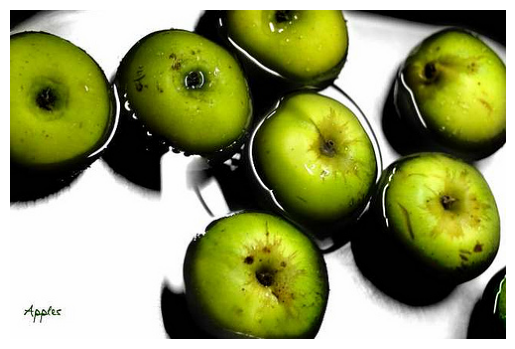

In [5]:
img = Image.open('./data/mirflickr/mirflickr/im30.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()


Image Feature Extraction 

In [6]:
# Method 1: Using Pretrained ResNet50 to extract image features

# device = 'cuda:4' if torch.cuda.is_available() else 'cpu'
# resnet = models.resnet50(pretrained=True)
# resnet.fc = nn.Identity()
# resnet = resnet.to(device).eval()

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

# def extract_image_features(img_dir="./data/mirflickr/mirflickr"):
#     feats, names = [], []
#     for fname in tqdm(sorted(os.listdir(img_dir)), desc="Extracting CNN features"):
#         if not fname.endswith(".jpg"): continue
#         path = os.path.join(img_dir, fname)
#         img = Image.open(path).convert("RGB")
#         x = transform(img).unsqueeze(0).to(device)
#         with torch.no_grad():
#             feat = resnet(x).cpu().numpy().flatten()
#         feats.append(feat)
#         names.append(fname.split('.')[0])
#     return np.vstack(feats), names

# image_feats, img_names = extract_image_features()
# np.savez("./data/mirflickr/image_features.npz", feats=image_feats, names=img_names)


In [7]:
# # Method 2: Using Custom EncoderCNN (ResNet50 backbone) to extract 512-dim image features


# class EncoderCNN(nn.Module):
#     def __init__(self, embed_size=512, train_cnn=False):
#         super().__init__()
#         # Load pretrained ResNet50
#         backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
#         modules = list(backbone.children())[:-1]   # remove final FC
#         self.cnn = nn.Sequential(*modules)
#         in_features = backbone.fc.in_features

#         # projection head (to lower dimension)
#         self.linear = nn.Linear(in_features, embed_size)
#         self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

#         # freeze CNN if not training
#         for param in self.cnn.parameters():
#             param.requires_grad = train_cnn

#     def forward(self, images):
#         out = self.cnn(images)          # (B, 2048, 1, 1)
#         out = out.view(out.size(0), -1) # flatten -> (B, 2048)
#         out = self.linear(out)          # (B, embed_size)
#         out = self.bn(out)
#         return out


# device = 'cuda:4' if torch.cuda.is_available() else 'cpu'
# encoder = EncoderCNN(embed_size=512, train_cnn=False).to(device)
# encoder.eval()

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])


# def extract_image_features(img_dir="./data/mirflickr/mirflickr", batch_size=128):
#     feats, names = [], []
#     files = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])

#     for i in tqdm(range(0, len(files), batch_size), desc="Extracting CNN features"):
#         batch_files = files[i:i+batch_size]
#         batch_imgs = []
#         for fname in batch_files:
#             path = os.path.join(img_dir, fname)
#             img = Image.open(path).convert("RGB")
#             batch_imgs.append(transform(img))
#         batch_tensor = torch.stack(batch_imgs).to(device)

#         with torch.no_grad():
#             feat = encoder(batch_tensor).cpu().numpy()
#         feats.append(feat)
#         names.extend([os.path.splitext(f)[0] for f in batch_files])

#     feats = np.vstack(feats)
#     return feats, names


# image_feats, img_names = extract_image_features()
# np.savez("./data/mirflickr/image_features_resnet50_512.npz", feats=image_feats, names=img_names)
# print(f"Saved features: {image_feats.shape}, Total images: {len(img_names)}")


In [8]:
data = np.load("./data/mirflickr/image_features.npz", allow_pickle=True)


image_feats = data["feats"]
img_names = data["names"]


print(len(image_feats[0]))


2048


In [9]:
sentences = list(img_tags.values())
w2v = Word2Vec(sentences, vector_size=200, window=1, min_count=30, workers=4)
w2v.save("./data/mirflickr/word2vec.model")

def tag_to_vec(tag):
    return w2v.wv[tag] if tag in w2v.wv else np.zeros(200)


In [10]:
print(f"Word2Vec vocab size: {len(w2v.wv)}")

Word2Vec vocab size: 868


In [11]:
meta_path = "./data/mirflickr/mirflickr/meta/tags"


files = sorted(os.listdir(meta_path))[:10]
print("Sample tag filenames:", files)


sample_file = os.path.join(meta_path, files[0])
print("\nSample file:", sample_file)
with open(sample_file) as f:
    print("First 200 chars:\n", f.read(200))


Sample tag filenames: ['tags1.txt', 'tags10.txt', 'tags100.txt', 'tags1000.txt', 'tags10000.txt', 'tags10001.txt', 'tags10002.txt', 'tags10003.txt', 'tags10004.txt', 'tags10005.txt']

Sample file: ./data/mirflickr/mirflickr/meta/tags/tags1.txt
First 200 chars:
 governorsisland
cigarette
tattoos
smoke
red
lipstick
dress
sunglasses
shades
belt



In [12]:
img_tags_fixed = {k.replace("tags", "im"): v for k, v in img_tags.items()}


print("Example fixed tag names:", list(img_tags_fixed.keys())[:5])


Example fixed tag names: ['im1718', 'im17093', 'im18593', 'im24664', 'im19379']


In [13]:
img_ids = sorted([int(n.replace("im", "")) for n in img_names if n.replace("im", "").isdigit()])
tag_ids = sorted([int(n.replace("tags", "")) for n in img_tags.keys() if n.replace("tags", "").isdigit()])

print(f"Total images: {len(img_ids)}, Total tag files: {len(tag_ids)}")
print(f"First 5 image IDs: {img_ids[:5]}")
print(f"First 5 tag IDs: {tag_ids[:5]}")
print(f"Common IDs: {len(set(img_ids).intersection(tag_ids))}")


Total images: 25000, Total tag files: 25000
First 5 image IDs: [1, 2, 3, 4, 5]
First 5 tag IDs: [1, 2, 3, 4, 5]
Common IDs: 25000


In [14]:
print("Number of .jpg files in image directory:",len([f for f in os.listdir("./data/mirflickr/mirflickr") if f.endswith(".jpg")]))


Number of .jpg files in image directory: 25000


In [15]:
print("Number of extracted features:", len(img_names))


Number of extracted features: 25000


Loading Dataset for Training

In [16]:

class FlickrDataset(Dataset):
    def __init__(self, feats, names, tags):
        self.data, self.labels = [], []
        name2feat = dict(zip(names, feats))
        for name, taglist in tags.items():
            if name in name2feat:
                feat = name2feat[name]
                for tag in taglist:
                    if tag in w2v.wv:
                        self.data.append(feat)
                        self.labels.append(tag_to_vec(tag))
        self.data, self.labels = np.stack(self.data), np.stack(self.labels)
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y

# dataset = FlickrDataset(image_feats, img_names, img_tags)
dataset = FlickrDataset(image_feats, img_names, img_tags_fixed)
loader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=2)
print(f"Dataset size: {len(dataset)} samples")


Dataset size: 82027 samples


CGAN Architecture

In [19]:
img_dim = 2048


class Generator(nn.Module):
    def __init__(self, noise_dim=100, img_dim=img_dim, hidden1=500, hidden2=2000, out_dim=200):
        super().__init__()
        self.z_fc = nn.Sequential(nn.Linear(noise_dim, hidden1), nn.ReLU(True))
        self.img_fc = nn.Sequential(nn.Linear(img_dim, hidden2), nn.ReLU(True))
        self.joint = nn.Linear(hidden1 + hidden2, out_dim)
    def forward(self, z, img_feat):
        h1 = self.z_fc(z)
        h2 = self.img_fc(img_feat)
        return self.joint(torch.cat([h1, h2], dim=1))

class Discriminator(nn.Module):
    def __init__(self, img_dim=img_dim, word_dim=200, hidden1=1200, hidden2=500):
        super().__init__()
        self.word_fc = nn.Sequential(nn.Linear(word_dim, hidden2), nn.ReLU(True))
        self.img_fc = nn.Sequential(nn.Linear(img_dim, hidden1), nn.ReLU(True))
        self.joint = nn.Sequential(nn.Linear(hidden1 + hidden2, 1000), nn.ReLU(True),
                                   nn.Linear(1000, 1), nn.Sigmoid())
    def forward(self, img_feat, word_vec):
        w = self.word_fc(word_vec)
        i = self.img_fc(img_feat)
        return self.joint(torch.cat([i, w], dim=1))


In [20]:
#display the architectures

G = Generator()
D = Discriminator()
print(G)
print(D)

Generator(
  (z_fc): Sequential(
    (0): Linear(in_features=100, out_features=500, bias=True)
    (1): ReLU(inplace=True)
  )
  (img_fc): Sequential(
    (0): Linear(in_features=2048, out_features=2000, bias=True)
    (1): ReLU(inplace=True)
  )
  (joint): Linear(in_features=2500, out_features=200, bias=True)
)
Discriminator(
  (word_fc): Sequential(
    (0): Linear(in_features=200, out_features=500, bias=True)
    (1): ReLU(inplace=True)
  )
  (img_fc): Sequential(
    (0): Linear(in_features=2048, out_features=1200, bias=True)
    (1): ReLU(inplace=True)
  )
  (joint): Sequential(
    (0): Linear(in_features=1700, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1000, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


Training Loop

In [32]:
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
G = Generator().to(device)
D = Discriminator().to(device)
criterion = nn.BCELoss()
opt_D = optim.SGD(D.parameters(), lr=0.01, momentum=0.5)
opt_G = optim.SGD(G.parameters(), lr=0.01, momentum=0.5)
# Adam optimizer
# opt_G = optim.Adam(G.parameters(), lr=0.01, betas=(0.5, 0.999))
# opt_D = optim.Adam(D.parameters(), lr=0.01, betas=(0.5, 0.999))
decay, min_lr = 1.00004, 1e-4

num_epochs = 50

for epoch in range(num_epochs):
    loop = tqdm(loader, leave=False)
    loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

    total_D, total_G, count = 0.0, 0.0, 0

    for img_feat, word_vec in loop:
        img_feat, word_vec = img_feat.to(device), word_vec.to(device)
        bsz = img_feat.size(0)
        count += 1

        # --- Train Discriminator ---
        z = torch.randn(bsz, 100, device=device)
        fake_words = G(z, img_feat)
        real_labels = torch.ones(bsz, 1, device=device)
        fake_labels = torch.zeros(bsz, 1, device=device)

        loss_D = (
            criterion(D(img_feat, word_vec), real_labels) +
            criterion(D(img_feat, fake_words.detach()), fake_labels)
        )

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # --- Train Generator ---
        loss_G = criterion(D(img_feat, fake_words), real_labels)
        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        # --- Update learning rate ---
        for opt in [opt_G, opt_D]:
            for g in opt.param_groups:
                g['lr'] = max(min_lr, g['lr'] / decay)

        # --- Accumulate losses ---
        total_D += loss_D.item()
        total_G += loss_G.item()

        # --- Update tqdm bar ---
        loop.set_postfix({
            "D_loss": f"{loss_D.item():.4f}",
            "G_loss": f"{loss_G.item():.4f}",
            "lr": f"{opt_D.param_groups[0]['lr']:.6f}"
        })

    avg_D = total_D / count
    avg_G = total_G / count
    print(f"Epoch {epoch+1}/{num_epochs} | Avg D: {avg_D:.4f} | Avg G: {avg_G:.4f}")


Epoch 1/50 | Avg D: 1.3583 | Avg G: 0.7103


Epoch 2/50 | Avg D: 1.2511 | Avg G: 0.7698


Epoch 3/50 | Avg D: 1.2112 | Avg G: 0.7973


Epoch 4/50 | Avg D: 1.2713 | Avg G: 0.7662


Epoch 5/50 | Avg D: 1.2424 | Avg G: 0.8145


Epoch 6/50 | Avg D: 0.4804 | Avg G: 2.8626


Epoch 7/50 | Avg D: 0.5864 | Avg G: 2.3448


Epoch 8/50 | Avg D: 0.7484 | Avg G: 1.9113


Epoch 9/50 | Avg D: 0.8105 | Avg G: 2.7126


Epoch 10/50 | Avg D: 0.7501 | Avg G: 3.5307


Epoch 11/50 | Avg D: 0.6330 | Avg G: 4.9206


Epoch 12/50 | Avg D: 0.5968 | Avg G: 5.5692


Epoch 13/50 | Avg D: 0.6865 | Avg G: 4.9311


Epoch 14/50 | Avg D: 0.5602 | Avg G: 6.7484


Epoch 15/50 | Avg D: 0.4686 | Avg G: 7.6926


Epoch 16/50 | Avg D: 0.5400 | Avg G: 7.6408


Epoch 17/50 | Avg D: 0.4766 | Avg G: 8.2322


Epoch 18/50 | Avg D: 0.4550 | Avg G: 8.7195


Epoch 19/50 | Avg D: 0.5249 | Avg G: 8.7552


Epoch 20/50 | Avg D: 0.1577 | Avg G: 34.2591


Epoch 21/50 | Avg D: 0.0019 | Avg G: 45.9387


Epoch 22/50 | Avg D: 0.0004 | Avg G: 46.2465


Epoch 23/50 | Avg D: 0.0002 | Avg G: 46.3347


Epoch 24/50 | Avg D: 0.0001 | Avg G: 46.3746


Epoch 25/50 | Avg D: 0.0001 | Avg G: 46.3955


Epoch 26/50 | Avg D: 0.0001 | Avg G: 46.4085


Epoch 27/50 | Avg D: 0.0001 | Avg G: 46.4179


Epoch 28/50 | Avg D: 0.0001 | Avg G: 46.4231


Epoch 29/50 | Avg D: 0.0000 | Avg G: 46.4282


Epoch 30/50 | Avg D: 0.0000 | Avg G: 46.4302


Epoch 31/50 | Avg D: 0.0000 | Avg G: 46.4327


Epoch 32/50 | Avg D: 0.0000 | Avg G: 46.4332


Epoch 33/50 | Avg D: 0.0000 | Avg G: 46.4337


Epoch 34/50 | Avg D: 0.0000 | Avg G: 46.4355


Epoch 35/50 | Avg D: 0.0000 | Avg G: 46.4349


Epoch 36/50 | Avg D: 0.0000 | Avg G: 46.4349


Epoch 37/50 | Avg D: 0.0000 | Avg G: 46.4337


Epoch 38/50 | Avg D: 0.0000 | Avg G: 46.4333


Epoch 39/50 | Avg D: 0.0000 | Avg G: 46.4338


Epoch 40/50 | Avg D: 0.0000 | Avg G: 46.4333


Epoch 41/50 | Avg D: 0.0000 | Avg G: 46.4326


Epoch 42/50 | Avg D: 0.0000 | Avg G: 46.4327


Epoch 43/50 | Avg D: 0.0000 | Avg G: 46.4314


Epoch 44/50 | Avg D: 0.0000 | Avg G: 46.4295


Epoch 45/50 | Avg D: 0.0000 | Avg G: 46.4287


Epoch 46/50 | Avg D: 0.0000 | Avg G: 46.4301


Epoch 47/50 | Avg D: 0.0000 | Avg G: 46.4287


Epoch 48/50 | Avg D: 0.0000 | Avg G: 46.4271


Epoch 49/50 | Avg D: 0.0000 | Avg G: 46.4269


Epoch 50/50 | Avg D: 0.0000 | Avg G: 46.4271


Tag Generation

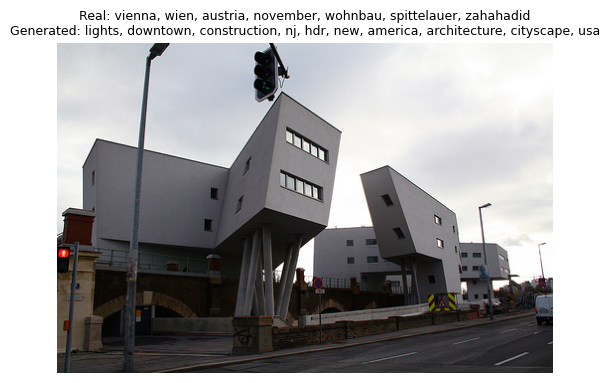

In [35]:

def generate_tags(G, img_feat, w2v, top_k=10, num_samples=100):
    img_feat = torch.tensor(img_feat, dtype=torch.float32).unsqueeze(0).to(device)
    samples = []
    for _ in range(num_samples):
        z = torch.randn(1, 100).to(device)
        word_vec = G(z, img_feat).detach().cpu().numpy()
        sims = cosine_similarity(word_vec, w2v.wv.vectors)[0]
        top_idx = np.argsort(sims)[-top_k:]
        samples.extend([w2v.wv.index_to_key[i] for i in top_idx])
    return pd.Series(samples).value_counts().head(top_k).index.tolist()

def visualize_example(img_path, real_tags, generated_tags):
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Real: {', '.join(real_tags)}\nGenerated: {', '.join(generated_tags)}", fontsize=9)
    plt.show()

sample_name = img_names[20000]
sample_img = image_feats[20000]
real_tags = img_tags_fixed.get(sample_name, [])
generated_tags = generate_tags(G, sample_img, w2v)
visualize_example(f"./data/mirflickr/mirflickr/{sample_name}.jpg", real_tags, generated_tags)
